<a href="https://colab.research.google.com/github/akhilagrawal1001/try-this/blob/master/ResNet34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, preprocessing
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Dense, Input, Flatten

In [ ]:
# To create a callback for avoiding overfitting in the model
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
def add_common(input):
  input = BatchNormalization()(input)
  input = LeakyReLU()(input)

  return input

In [ ]:
# There are two kinds of residual blocks possible

#This is an identity block where the input and residual are already in same shape.
'''
  # x = input_tensor
  # kernel_size = the kernel_size required for convulations
  # channels = number of channels in input /or/ residual since the are same XD.
  # repetitions = number of identitiy blocks to be made
'''
def iden(x, kernel_size, channels, repetitions):
  
  for i in range(repetitions):
    shortcut = x
    # padding is kept same so that dimensions before and after convulation is same.
    x = Conv2D(channels, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = add_common(x)
    x = Conv2D(channels, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    x = layers.add([x, shortcut])
    x = LeakyReLU()(x)

  return x
# This is a change residual block where input and residual are in different shape.

'''
  # x = input_tensor
  # kernel_size = the kernel_size required for convulations
  # out_channels = number of channels in *residual* tensor
  # stride =  striding if any used to obtain the residual from input
'''
def change(x, kernel, out_channels, stride = (1,1)):
  shortcut = x

  x = Conv2D(out_channels, kernel, padding='same', strides=stride)(x)
  x = add_common(x)
  x = Conv2D(out_channels, kernel, padding='same')(x)
  x = BatchNormalization()(x)

  # out_strid = (int(round(x.shape[1] / shortcut.shape[1])), int(round(x.shape[2] / shortcut.shape[2])))
  
  shortcut = Conv2D(out_channels, (1, 1), strides=stride, padding='same')(shortcut)
  shortcut = BatchNormalization()(shortcut)

  x = layers.add([x, shortcut])
  x = LeakyReLU()(x)

  return x



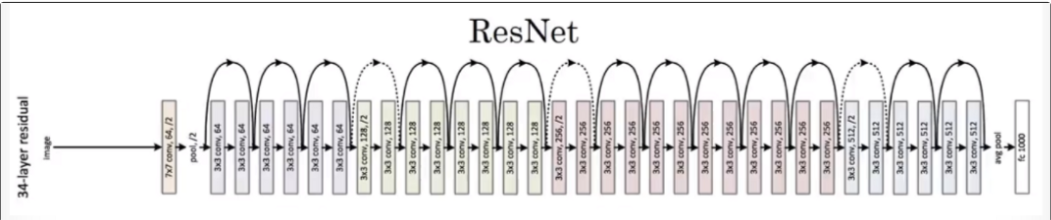

The above picture is of 34-layer Residual Neural Network, ResNet34 as given in the research paper.

It has the following network structure(Sequentially):


*   1 Conv layer of 64 channels
*   1 Pooling layer with (2, 2) stride
*   3 indentity residual blocks with 64 channels
*   1 change residual block with 128 output_channels
*   3 identity residual blocks with 128 channels
*   1 change residual block with 256 output channels
*   5 identity residual blocks with 256 channels
*   1 change residual block with 512 channels
*   2 identity residual blocks with 512 channels

Identity Residual Block and Change Residual Block are defined as functions iden() and change() respectively



In [ ]:
# This is our model function, that takes training_images as input tensor, and, 
# outputs the model prediction of that input.

def res_model(x):
  x =  Conv2D(64, (7, 7), padding='same', strides=(2, 2), kernel_initializer='glorot_uniform')(x)
  x = MaxPool2D(strides=(2, 2), padding='same')(x)
  x = iden(x, (3, 3), 64, 3)
  
  x = change(x, (3, 3), 128, (2,2))
  x = iden(x, (3,3), 128, 3)
  
  x = change(x, (3, 3), 256, (2,2))
  x = iden(x, (3,3), 256, 5)
  
  x = change(x, (3, 3), 512, (2,2))
  x = iden(x, (3,3), 512, 2)

  x = GlobalAveragePooling2D()(x)
  # 10 neurons due to 10 different labels in labels of cifar10 dataset
  x = Dense(10, activation='softmax', kernel_initializer='he_normal')(x)

  return x

In [ ]:
img_tensor = Input(shape=[32, 32, 3])
out = res_model(img_tensor)

model = models.Model(inputs=img_tensor, outputs=out)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 8, 8, 64)     0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 64)     36928       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:
cifar = tf.keras.datasets.cifar10
(training_images, training_labels), (test_images, test_labels) = cifar.load_data()

# Normalise the image so that each pixel in each channel has value in the range [0, 1)
training_images = training_images / 255.0
test_images = test_images / 255.0

val_img = training_images[-5000:]
val_labels = training_labels[-5000:]

training_images = training_images[:-5000]
training_labels = training_labels[:-5000]

In [ ]:
training_labels = keras.utils.to_categorical(training_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)
val_labels = keras.utils.to_categorical(val_labels, 10)

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
                                                          height_shift_range=0.1,
                                                          horizontal_flip=True, 
                                                          rotation_range=30)

datagen.fit(training_images)
data = datagen.flow(training_images, training_labels, batch_size = 32)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
callback1 = myCallback()
hist = model.fit(data, epochs=75, validation_data=(val_img, val_labels), callbacks=[callback1])

Epoch 1/75
1407/1407 [==============================] - 91s 40ms/step - loss: 1.8212 - accuracy: 0.3588 - val_loss: 1.6371 - val_accuracy: 0.4628
Epoch 2/75
1407/1407 [==============================] - 56s 40ms/step - loss: 1.5216 - accuracy: 0.4580 - val_loss: 1.6355 - val_accuracy: 0.4480
Epoch 3/75
1407/1407 [==============================] - 56s 40ms/step - loss: 1.4624 - accuracy: 0.4895 - val_loss: 1.7848 - val_accuracy: 0.4288
Epoch 4/75
1407/1407 [==============================] - 56s 40ms/step - loss: 1.3355 - accuracy: 0.5330 - val_loss: 1.1028 - val_accuracy: 0.6096
Epoch 5/75
1407/1407 [==============================] - 56s 40ms/step - loss: 1.2471 - accuracy: 0.5622 - val_loss: 2.1600 - val_accuracy: 0.3446
Epoch 6/75
1407/1407 [==============================] - 54s 39ms/step - loss: 1.1866 - accuracy: 0.5871 - val_loss: 1.1106 - val_accuracy: 0.5986
Epoch 7/75
1407/1407 [==============================] - 54s 38ms/step - loss: 1.1201 - accuracy: 0.6118 - val_loss: 0.9247 -

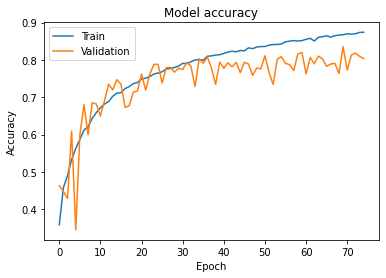

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

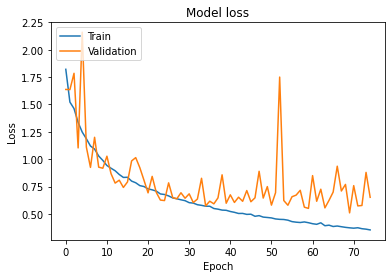

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_images, test_labels)

print("Loss on test data:", loss)
print("Accuracy on test data:", accuracy)


313/313 [==============================] - 4s 13ms/step - loss: 0.6837 - accuracy: 0.7958
Loss on test data: 0.6837095618247986
Accuracy on test data: 0.795799970626831
